In [ ]:
! pip install sklearn

# Imports

In [1]:
from fastai.text import *

In [2]:
import sys

sys.path.append("../../")
from eval.exp.nb_evaluation import *

sys.path.append("../../../")
from src.proc.exp.nb_proc import *
from src.prep.exp.nb_prep import *

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# setup paths and model type
model_path = Path("/tf/data/models")
data_path  = Path("/tf/data/datasets")

task_type = "merged"

# Load Data

In [ ]:
df_trn, df_val, df_tst = read_data(data_path/task_type)

In [5]:
bs = 8

Percentage of data to be used: sample 

In [ ]:
data = gen_lm_data(df_trn, df_val, task_type, data_path, bs = bs)
data.save(task_type + '/data_lm_100pct.pkl')

In [6]:
data = load_data(data_path/task_type, 'data_lm_100pct.pkl', bs=bs)

In [7]:
len(data.train_ds), len(data.valid_ds)

(492904, 105363)

# Model Setup

In [8]:
pretrained = False

In [9]:
# amit experiments
learn = language_model_learner(data, Transformer, drop_mult = 0.1, pretrained = pretrained, metrics=[accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


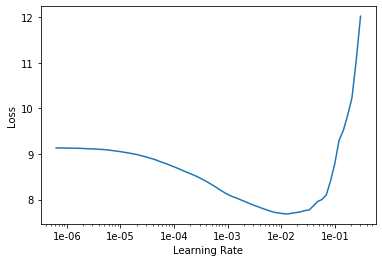

In [10]:
learn.lr_find()
learn.recorder.plot()

# Model Training

In [12]:
# Set hyperparameters
max_lr = 1e-2
moms = (0.5, .75)
pct_strt = 0.02
a_epochs = 3

In [13]:
callback_fns = [
    callbacks.SaveModelCallback(
        learn, every='improvement',
        monitor='valid_loss', name='transformer_save_model'
    ),
    callbacks.EarlyStoppingCallback(
        learn, monitor='valid_loss', min_delta = 0.01,
        patience = 3
    )
]

In [ ]:
#amit experiments
learn.fit_one_cycle(a_epochs, max_lr, callbacks = callback_fns) #, moms=moms, pct_start = pct_strt)

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.load('transformer_save_model')

In [ ]:
# learn.recorder.plot_losses()
figure_plot = learn.recorder.plot_losses(return_fig=True)
figure_plot.savefig(fname="transformer_plot_losses.png", format='png')

In [ ]:

from PIL import Image
Image.open('/tf/main/nbs/mdling/transformer/transformer_plot_losses.png')

# Model Evaluation

In [ ]:
print(df_val["query"][50000])
print("\n\n" + df_val["res"][50000])

In [ ]:
print(df_val["query"][75_000])
print("\n\n" + df_val["res"][75_000])

In [ ]:
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.Load(str(data_path/"merged/model.model"))

In [ ]:
TEXT = df_val["query"][500]
N_WORDS = 200
N_SENTENCES = 2

In [ ]:
print(TEXT)
df_val["res"][500]

In [ ]:
print(sp.DecodePieces(learn.predict(TEXT, 100, temperature=0.75).split(" ")))

# Evaluation

In [ ]:
learn.predict??

In [ ]:
# Grabs entire model's response up until special xxbos token,
# i.e. once model begins a new sentence we consider the model finished with its answer.
def get_res(mdl, inpt, n_toks = 1_000):
    res = mdl.predict(inpt, n_toks, temperature=0.75).split(" ")
    res = sp.DecodePieces(res).split(" ")
    try:
        end_res = res.index("xxbos")
    except:
        end_res = len(res) - 1
    
    res = " ".join(res[:end_res])[len(inpt.replace(" ", '')):]
    
    return res

In [ ]:
res = get_res(learn, "public static void main() {return;}<$bug$>", n_toks = 10)
res # [0:len("public static void main() {return;}<$bug$>")]

In [ ]:
#export
def eval_txt(mdl, ds):
    b1, b2, b3, b4 = [], [], [], []
    meteor = []
    rouge_l = []
    preds = []
    tokenizer = Tokenizer()
    for inpt, lbl in zip(ds["query"], ds["res"]):
        tok_len = len(sp.EncodeAsPieces(inpt))
        if tok_len > 1024:
            continue
            
        pred = get_res(mdl, inpt, n_toks = 600)
        
        tokens = tokenizer.process_all([lbl])
        print(tokens)
        lbl = ' '.join(tokens[0])
        print(lbl)
        preds.append(pred)
        # bleu 1-4
        b1.append(eval_bleu1([lbl], pred))
        b2.append(eval_bleu2([lbl], pred))
        b3.append(eval_bleu3([lbl], pred))
        b4.append(eval_bleu4([lbl], pred))
        
        # meteor
        meteor.append(eval_meteor([lbl], pred))
        
        # rouge
        rouge_l.append(eval_rougeL_single_ref([lbl], pred))
        
    return b1, b2, b3, b4, meteor, rouge_l, preds

In [ ]:
tokenizer = Tokenizer()
tokens = tokenizer.process_all(df_val[-10:-9]['res'])
# tokens
' '.join(tokens[0])

In [ ]:
df_val.tail(10)

In [ ]:
from statistics import mean, median, stdev

In [ ]:
preds[2]

In [ ]:
str(df_val['query'][len(df_val) - 8])

In [ ]:
b1, b2, b3, b4, meteor, rouge_l, preds  = eval_txt(learn, df_val[-10:])

In [ ]:
preds

In [ ]:
b1

In [ ]:
mean(rougue)

In [ ]:
df_val[-100:-95]

In [ ]:
preds[4]

In [ ]:
df_val[-10:]

In [ ]:
rouge_l[0]

In [ ]:
mean(rouge_l[:][0]), mean(rouge_l[:][1]), mean(rouge_l[:][2])#, preds[:10]

In [ ]:
# Evaluation metrics for vulnerability detection - Accuracy, Precision, Recall
def eval_vuln(mdl, tst):
    tps, tns, fps, fns = 0, 0, 0, 0
    tot = 0
    for inpt, lbl in zip(tst["query"], tst["res"]):
        tok_len = len(sp.EncodeAsPieces(inpt))
        if tok_len > 1024:
#             print("Skipping because size is too big", tok_len)
            continue
        pred = get_res(mdl, inpt, n_toks = 10)
        if lbl == "yes":
            if pred == lbl:
                tps += 1
            else: fns += 1
        else:
            if pred == lbl:
                tns += 1
            else: fps += 1
                
        tot += 1
        torch.cuda.empty_cache()
            
    acc   = (tps + tns) / tot
    prec  = tps / (tps + fps) if (tps + fps) != 0 else 0.
    recal = tps / (tps + fns) if (tps + fns) != 0 else 0.
    
    return acc, prec, recal

In [ ]:
acc, prec, recal = eval_vuln(learn, df_val[:1000])

In [ ]:
acc, prec, recal

In [ ]:
len(df_val[:10])

In [ ]:
import torch
torch.cuda.empty_cache()